In [20]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
    
# Import libraries
import os
import sys
import time
import math
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.models as models
import torchvision.utils
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from data_utils import create_validation_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
# Returns a torchvision model by name
def get_model(model_name, pretrained= True):
    return models.__dict__[model_name](pretrained)

# Displays an image tensor
def imshow(img, text= None):
    img_np = img.numpy().transpose((1, 2, 0))
    plt.axis('off')
    if text:
        plt.text(175, 8, text, style='italic', fontweight='bold',
                bbox= {'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(img_np)
    plt.show()

In [25]:
DATA_DIR= 'datasets/att_face'
trn_dir = f'{DATA_DIR}/train'
val_dir = f'{DATA_DIR}/valid'

batch_size= 16
embed_size= 128
num_epochs= 10
sz= 96
cnn_name= 'resnet50'

In [26]:
fname= glob.glob(f'{trn_dir}/*/*.pgm')
fname[:5]

['/content/drive/MyDrive/deep learning/Week 02/datasets/att_face/train/s1/5.pgm',
 '/content/drive/MyDrive/deep learning/Week 02/datasets/att_face/train/s1/6.pgm',
 '/content/drive/MyDrive/deep learning/Week 02/datasets/att_face/train/s1/8.pgm',
 '/content/drive/MyDrive/deep learning/Week 02/datasets/att_face/train/s1/1.pgm',
 '/content/drive/MyDrive/deep learning/Week 02/datasets/att_face/train/s1/3.pgm']

In [32]:
for f in fname[:5]:
    print(os.path.basename(f))

5.pgm
6.pgm
8.pgm
1.pgm
3.pgm


In [33]:
# make validation dataset
if not os.path.exists(val_dir):
    create_validation_data(trn_dir, val_dir, split=0.20, ext='pgm')

400
80


100%|██████████| 80/80 [00:00<00:00, 231.67it/s]


In [34]:
class TripletNetworkDataset(Dataset):
    """
    Custom dataset for generating triplets (anchor, positive, negative) for triplet loss training.
    """

    def __init__(self, imgs, transform=None):
        self.imgs = imgs
        self.transform = transform or transforms.ToTensor()

    def __getitem__(self, index):
        anchor, anchor_label = self.imgs[index]

        # Select a positive sample
        positive = random.choice([img for img, lbl in self.imgs if lbl == anchor_label])
        # Select a negative sample
        negative = random.choice([img for img, lbl in self.imgs if lbl != anchor_label])

        anc_img = Image.open(anchor).convert('RGB')
        pos_img = Image.open(positive).convert('RGB')
        neg_img = Image.open(negative).convert('RGB')

        if self.transform is not None:
            anc_img = self.transform(anc_img)
            pos_img = self.transform(pos_img)
            neg_img = self.transform(neg_img)

        return anc_img, pos_img, neg_img

    def __len__(self):
        return len(self.imgs)

In [35]:
zoom = int((1.0 + random.random() / 10.0) * sz)

# Define training data transformations (augmentation)
train_tfms = transforms.Compose([
    transforms.Resize((zoom,zoom)),
    transforms.RandomCrop(sz),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ToTensor()
])

# Create training dataset and dataloader
face_dataset = datasets.ImageFolder(trn_dir)
train_ds = TripletNetworkDataset(face_dataset.imgs, transform=train_tfms)
train_dl = DataLoader(train_ds, batch_size=8, shuffle= True, num_workers=0)

In [36]:
# Define validation data transformations (no augmentation)
valid_tfms = transforms.Compose([
    transforms.Resize((zoom,zoom)),
    transforms.ToTensor()
])

# Create validation dataset and dataloader
valid_face_dataset = datasets.ImageFolder(val_dir)
valid_ds = TripletNetworkDataset(valid_face_dataset.imgs, transform=valid_tfms)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle= False, num_workers=0)

### Visualize dataset

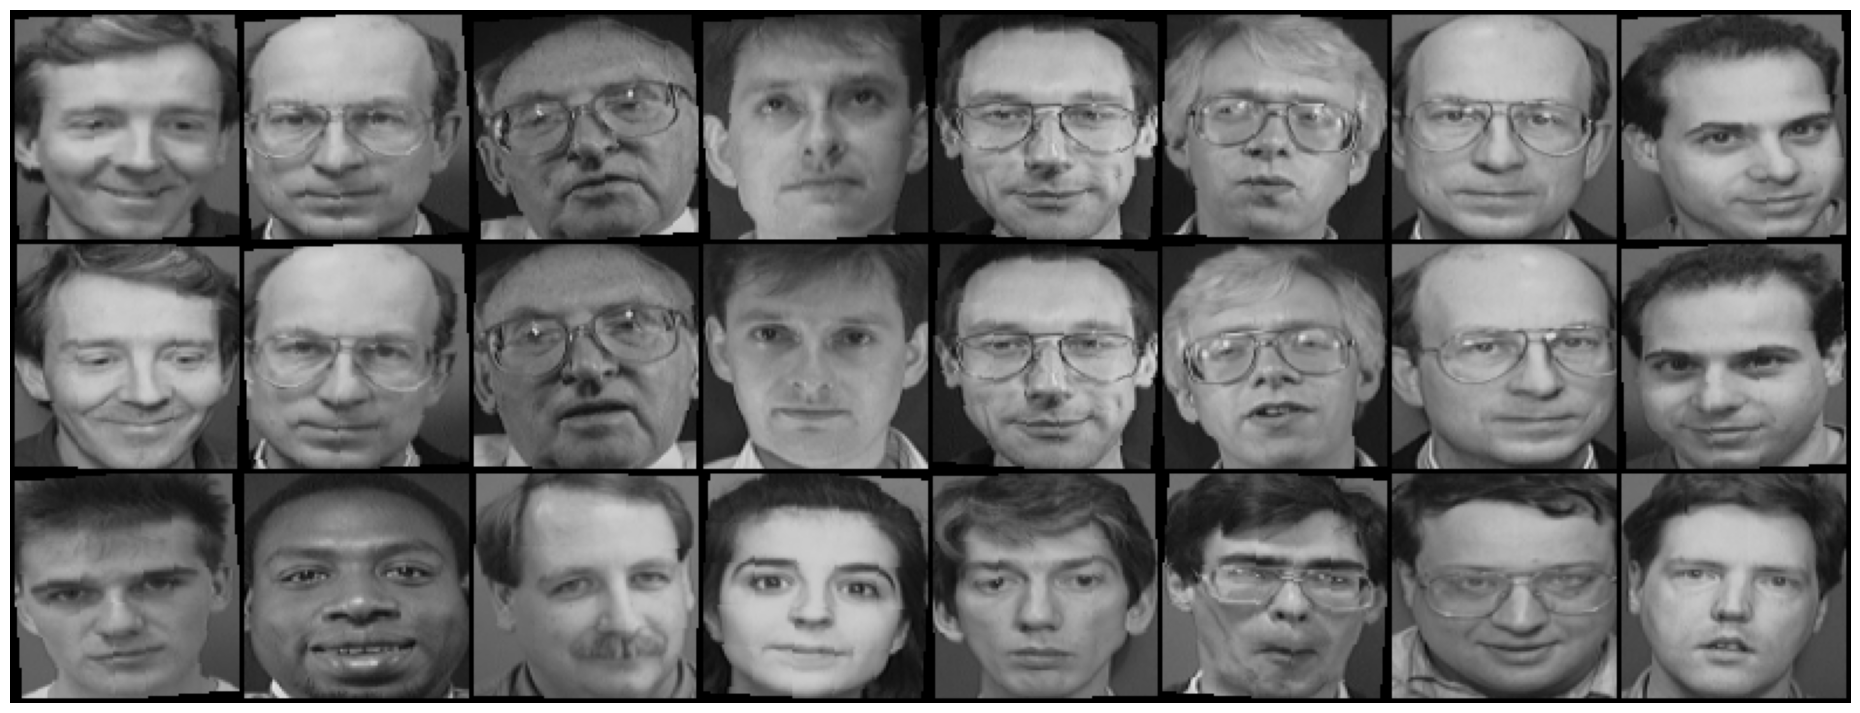

In [37]:
anc, pos, neg = next(iter(train_dl))
concat = torch.cat((anc, pos, neg), 0)
plt.figure(figsize=(24, 9))
imshow(torchvision.utils.make_grid(concat, nrow=8))
plt.show()

In [38]:
class TripletNetwork(nn.Module):
    """
    Neural network for learning embeddings using triplet loss.
    The final layer of the base model is replaced with a custom embedding head.
    """
    def __init__(self, model, embed_size):
        super(TripletNetwork, self).__init__()
        num_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, embed_size)
        )
        self.model = model
        
    def forward(self, anc, pos, neg):
        # Forward pass for anchor, positive, and negative images
        anc = self.model(anc)
        pos = self.model(pos)
        neg = self.model(neg)

        return anc, pos, neg

In [39]:
class TripletLoss(nn.Module):
    """
    Triplet loss function for training the network.
    """
    def __init__(self, margin= 0.2):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anc_f, pos_f, neg_f):
        pos_distance = F.pairwise_distance(anc_f, pos_f)
        neg_distance = F.pairwise_distance(anc_f, neg_f)
        # Compute loss as described in the triplet loss formula
        loss = torch.sum(torch.clamp(torch.pow(pos_distance, 2) - torch.pow(neg_distance, 2) + self.margin, min= 0))
        return loss


In [40]:
def train_step(model, train_dl, criterion, optimizer, device):
    """
    Performs one training epoch over the training dataloader.
    """
    model.train()
    N = len(train_dl.dataset)
    step = N // train_dl.batch_size
    avg_loss = 0.0
    for i, (anc, pos, neg) in enumerate(train_dl):
        anc, pos, neg = anc.to(device), pos.to(device), neg.to(device)

        # forward
        f_anc, f_pos, f_neg = model(anc, pos, neg)

        #Loss
        loss = criterion(f_anc, f_pos, f_neg)
        avg_loss = (avg_loss * i + loss.item()) / (i + 1)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Report
        sys.stdout.flush()
        sys.stdout.write("\r Training Step[{:2d} / {:2d}] : loss {:.5f}"
                        .format(i+1, step, avg_loss))
    print()

    return model, avg_loss


def validate_step(model, valid_dl, criterion, device):
    model.eval()
    N = len(valid_dl.dataset)
    step = N // valid_dl.batch_size
    avg_loss = 0
    with torch.no_grad():
        for i, (anc, pos, neg) in enumerate(valid_dl):
            anc, pos, neg = anc.to(device), pos.to(device), neg.to(device)


            # forward
            f_anc, f_pos, f_neg = model(anc, pos, neg)

            #Loss
            loss = criterion(f_anc, f_pos, f_neg)
            avg_loss = (avg_loss * i + loss.item()) / (i + 1)

            # Report
            sys.stdout.flush()
            sys.stdout.write("\r Validation Step[{:2d} / {:2d}] : loss {:.5f}"
                            .format(i+1, step, avg_loss))
    print()
    return avg_loss


def train(model, train_dl, valid_dl, optimizer, criterion,device, scheduler=None, num_epochs= 10):
    """
    Trains the model for a specified number of epochs, keeping track of the best weights.
    """
    best_loss = float('inf')
    best_weights = model.state_dict().copy()
    train_loss_history, valid_loss_history = [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch +1} | {num_epochs}\n------------')

        model, train_loss = train_step(model, train_dl, criterion, optimizer, device)
        valid_loss = validate_step(model, valid_dl, criterion,device)

        if scheduler:
            scheduler.step()

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        if valid_loss < best_loss:
            best_loss = valid_loss
            best_weights = model.state_dict().copy()

        print()
    loss_history = (train_loss_history, valid_loss_history)
    model.load_state_dict(best_weights)
    return model, best_weights, loss_history

In [41]:
train_dl = DataLoader(train_ds, batch_size= batch_size, shuffle=True, num_workers=0)
valid_dl = DataLoader(valid_ds, batch_size= batch_size, shuffle=True, num_workers=0)

# Initialize the base CNN
cnn = get_model(cnn_name)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TripletNetwork(cnn, embed_size).to(device)

# Define loss function, optimizer, and learning rate scheduler
criterion = TripletLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0002)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5 , gamma= 0.5)

In [42]:
# Train the model
model, best_weights, loss_hist = train(
    model, train_dl, valid_dl,
    optimizer, criterion,
    device,
    scheduler,
    num_epochs=num_epochs
)


Epoch 1 | 10
------------
 Training Step[20 / 20] : loss 14.35809
 Validation Step[ 5 /  5] : loss 0.00000

Epoch 2 | 10
------------
 Training Step[20 / 20] : loss 10.74852
 Validation Step[ 5 /  5] : loss 4.75567

Epoch 3 | 10
------------
 Training Step[20 / 20] : loss 7.96676
 Validation Step[ 5 /  5] : loss 0.27903

Epoch 4 | 10
------------
 Training Step[20 / 20] : loss 6.68232
 Validation Step[ 5 /  5] : loss 0.12179

Epoch 5 | 10
------------
 Training Step[20 / 20] : loss 7.05536
 Validation Step[ 5 /  5] : loss 4.11634

Epoch 6 | 10
------------
 Training Step[20 / 20] : loss 3.17608
 Validation Step[ 5 /  5] : loss 1.39149

Epoch 7 | 10
------------
 Training Step[20 / 20] : loss 5.26524
 Validation Step[ 5 /  5] : loss 1.77689

Epoch 8 | 10
------------
 Training Step[20 / 20] : loss 5.20024
 Validation Step[ 5 /  5] : loss 2.86938

Epoch 9 | 10
------------
 Training Step[20 / 20] : loss 1.04329
 Validation Step[ 5 /  5] : loss 0.79787

Epoch 10 | 10
------------
 Trainin

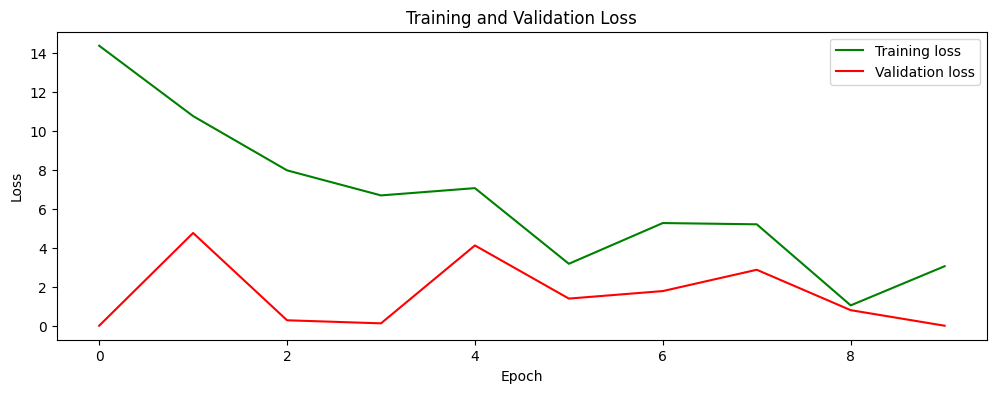

In [43]:
# Plot training and validation loss curves
plt.figure(figsize=(12, 4))
plt.plot(loss_hist[0], 'g', label='Training loss')
plt.plot(loss_hist[1], 'r', label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Training and Validation Loss");

In [44]:
valid_dl = DataLoader(valid_ds, batch_size=1, shuffle=True)

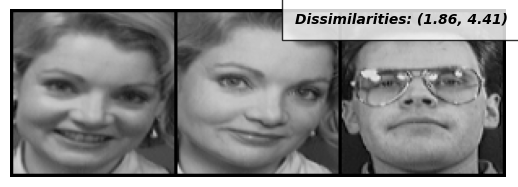

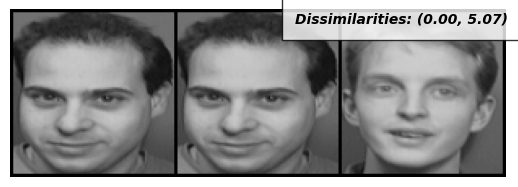

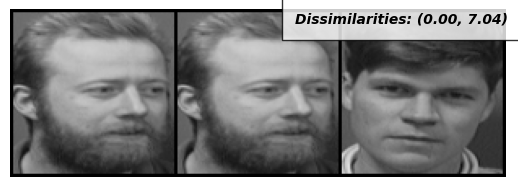

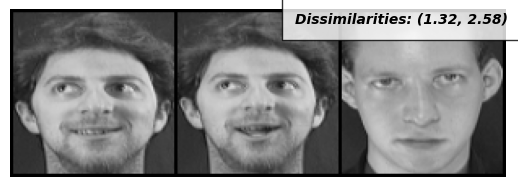

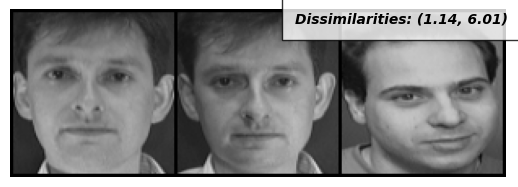

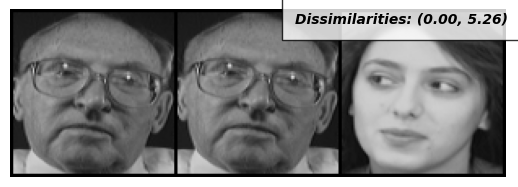

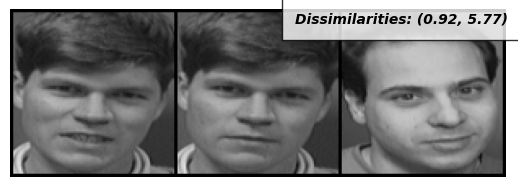

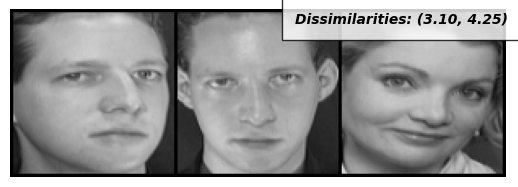

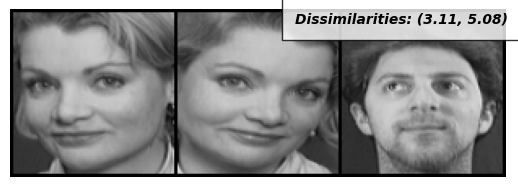

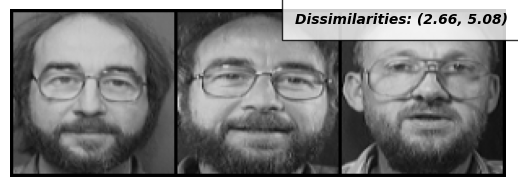

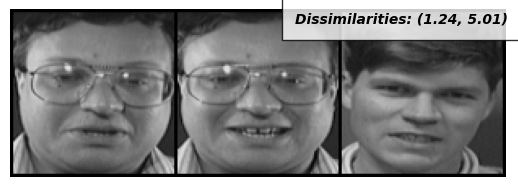

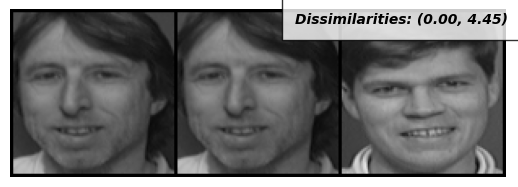

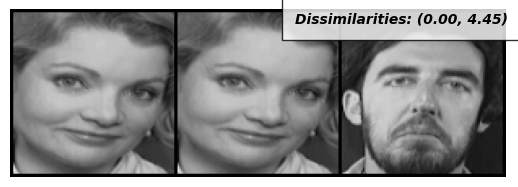

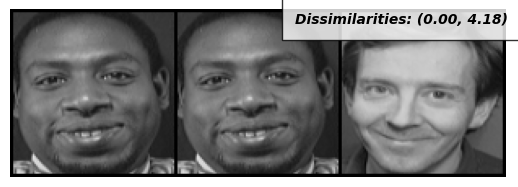

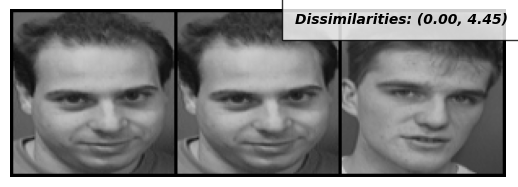

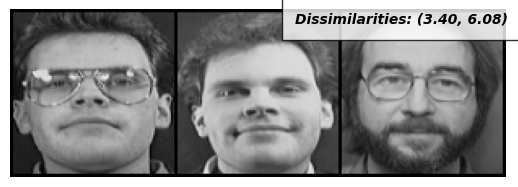

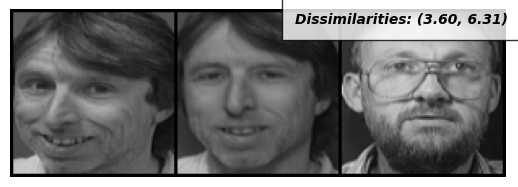

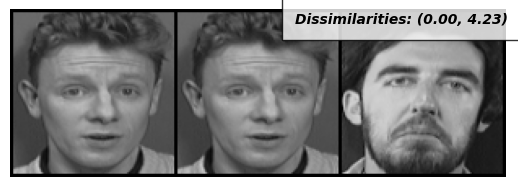

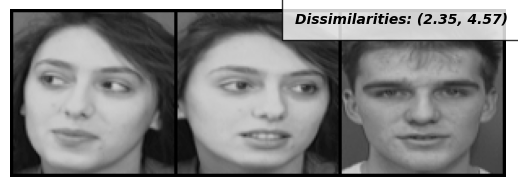

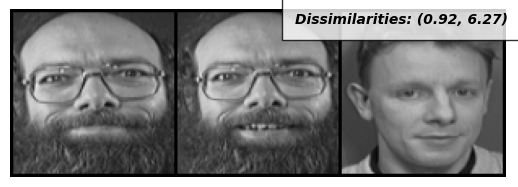

In [45]:
# Evaluate the model on a few random triplets from the validation set and visualize distances
model.eval()
dataiter = iter(valid_dl)

with torch.no_grad():
    for i in range(20):
        x0, x1, x2 = next(dataiter)
        concat = torch.cat((x0, x1, x2), 0)
        f0, f1, f2 = model(x0.to(device), x1.to(device), x2.to(device))
        pos_distance = F.pairwise_distance(f0, f1)
        neg_distance = F.pairwise_distance(f0, f2)
        imshow(torchvision.utils.make_grid(concat), f'Dissimilarities: ({pos_distance.item():.2f}, {neg_distance.item():.2f})')